# Scrape daily regional gas prices from AAA and plot trends over time.

In [1]:
import certifi
import urllib3
http = urllib3.PoolManager(
cert_reqs='CERT_REQUIRED',
ca_certs=certifi.where())

In [2]:
from lxml import html  
from lxml.html import fromstring
import requests
from itertools import cycle
import re
import datetime, time
from time import sleep
import pandas as pd
import math
from bs4 import BeautifulSoup
import numpy
from urllib.request import Request, urlopen
from urllib.error import URLError
import ssl
from fake_useragent import UserAgent
import matplotlib.pyplot as plt

In [3]:
def get_soup(url):
            
            context = ssl._create_unverified_context()
            retries = 2
    
            wait_time = 5
            read_url = None
            soup = ""
            tries = 1
            req = Request(url)
            req.add_header('User-agent', str(ua.random))
    
            # access url, with exponential back-off in event of failure
            while read_url is None:
                try:
                    read_url = urlopen(req, context=context).read()
                    soup = BeautifulSoup(read_url, "lxml")
                except URLError:
                    for i in range(20):
                        # Generating random delays
                        sleep(numpy.random.randint(1,3))
                        # Adding verify=False to avold ssl related issues
                    if tries == retries:
                        soup = ""
    
            return soup

In [8]:
#get state abbreviations
ua = UserAgent()
url = "http://www.stateabbreviations.us/"
states = get_soup(url)
datas = states.find('table')
sdat = [[k.get_text().strip() for k in x.findAll('td')] for x in datas.findAll('tr')[5:]]
sdat = [x for x in sdat[0:52] if len(x) > 1]
sdat = pd.DataFrame(sdat)
sdat = sdat.iloc[1:]

In [9]:
#Loop through states
basePage = 'https://gasprices.aaa.com/'
base = get_soup(basePage)

natap = base.find('div',{'class' : 'average-price'}).get_text().strip()
natap = natap.split('\n')
natap = natap[len(natap) - 1].strip().replace('  ',' ')
sstat_tab = base.find('table')
sstats = [[k.get_text().strip() for k in x.findAll('td')] for x in sstat_tab.findAll('tr')]
sstats[0] = ['header','regular','mid-grade','premium','diesel','e85']
sstats[0].append('state')
[sstats[x].append('national') for x in range(1,len(sstats))]
sdate = datetime.datetime.now().strftime("%Y-%m-%d")
sstats[0].append('scrape_date')        
[sstats[x].append(sdate) for x in range(1,len(sstats))]        
sstats[0].append('updated')        
[sstats[x].append(natap) for x in range(1,len(sstats))]        
datas = sstats.copy()

states = sdat[2]
for st in states:
    url = "http://gasprices.aaa.com/?state={0}".format(st)
    soup = get_soup(url)
    sstat_tab = soup.find('table')
    if st != 'Postal':
        sstats = [[k.get_text().strip() for k in x.findAll('td')] + ['',st,sdate,natap] 
        for x in sstat_tab.findAll('tr')]
    else:
        sstats = [[k.get_text().strip() for k in x.findAll('td')] + [st,sdate,natap] 
        for x in sstat_tab.findAll('tr')]                
    datas += sstats[1:]
    print("Scraped {0}".format(st))
    time.sleep(5)

datas = datas
print("Finished all states")

Scraped AL
Scraped AK
Scraped AZ
Scraped AR
Scraped CA
Scraped CO
Scraped CT
Scraped DE
Scraped FL
Scraped GA
Scraped HI
Scraped ID
Scraped IL
Scraped IN
Scraped IA
Scraped KS
Scraped KY
Scraped LA
Scraped ME
Scraped MD
Scraped MA
Scraped MI
Scraped MN
Scraped MS
Scraped MO
Scraped MT
Scraped NE
Scraped NV
Scraped NH
Scraped NJ
Scraped NM
Scraped NY
Scraped NC
Scraped ND
Scraped OH
Scraped OK
Scraped OR
Scraped PA
Scraped RI
Scraped SC
Scraped SD
Scraped TN
Scraped TX
Scraped UT
Scraped VT
Scraped VA
Scraped WA
Scraped WV
Scraped WI
Scraped WY
Finished all states


In [10]:
df1 = pd.DataFrame(datas)
df = df1.iloc[1:]
df = df.rename(index=str,columns={0: "Header",1: "Regular",2:"Midgrade",3:"Premium",4:"Diesel",5:"e85",6:"State",7:"ScrapeDate",8:"Updated"})
df.head()

,Header,Regular,Midgrade,Premium,Diesel,e85,State,ScrapeDate,Updated
1,Current Avg.,$2.820,$3.141,$3.395,$3.085,$2.410,national,2019-06-01,Price as of6/1/19
2,Yesterday Avg.,$2.825,$3.142,$3.398,$3.088,$2.402,national,2019-06-01,Price as of6/1/19
3,Week Ago Avg.,$2.838,$3.161,$3.414,$3.099,$2.413,national,2019-06-01,Price as of6/1/19
4,Month Ago Avg.,$2.882,$3.189,$3.443,$3.101,$2.439,national,2019-06-01,Price as of6/1/19
5,Year Ago Avg.,$2.952,$3.236,$3.484,$3.211,$2.474,national,2019-06-01,Price as of6/1/19


In [11]:
#National price only
nat = df[df['State'].isin(['national'])]

In [12]:
nat = nat.sort_values(['Regular'])
p = [nat["Regular"][i].replace('$','') for i in range(0,len(nat['Regular']))]
for i in range(0,len(p)):
    p[i] = float(p[i])
p

[2.82, 2.825, 2.838, 2.882, 2.952]

In [13]:
h = [nat["Header"][i].replace('Avg.','').strip(' ') for i in range(0,len(nat['Header']))]
h

['Current', 'Yesterday', 'Week Ago', 'Month Ago', 'Year Ago']

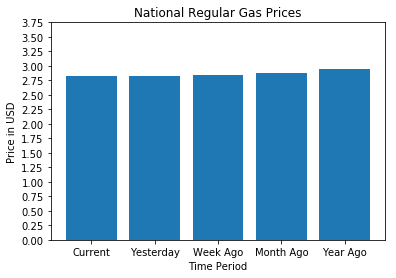

In [14]:
plt.bar(h,p)
plt.yticks(numpy.arange(0,4,.25))
plt.ylabel('Price in USD')
plt.xlabel('Time Period')
plt.title('National Regular Gas Prices')
plt.show()

In [15]:
#regular current price by state
state = df[df['Header'].isin(['Current Avg.'])]
state = state.iloc[1:]
state = state.sort_values(['Regular'])

In [16]:
p = [state["Regular"][i].replace('$','') for i in range(0,len(state['Regular']))]
for i in range(0,len(p)):
    p[i] = float(p[i])
p.sort()

In [17]:
ref = df[df['State'].isin(['national'])&df['Header'].isin(['Current Avg.'])]
ref = ref['Regular'][0].replace('$','')
ref = float(ref) 

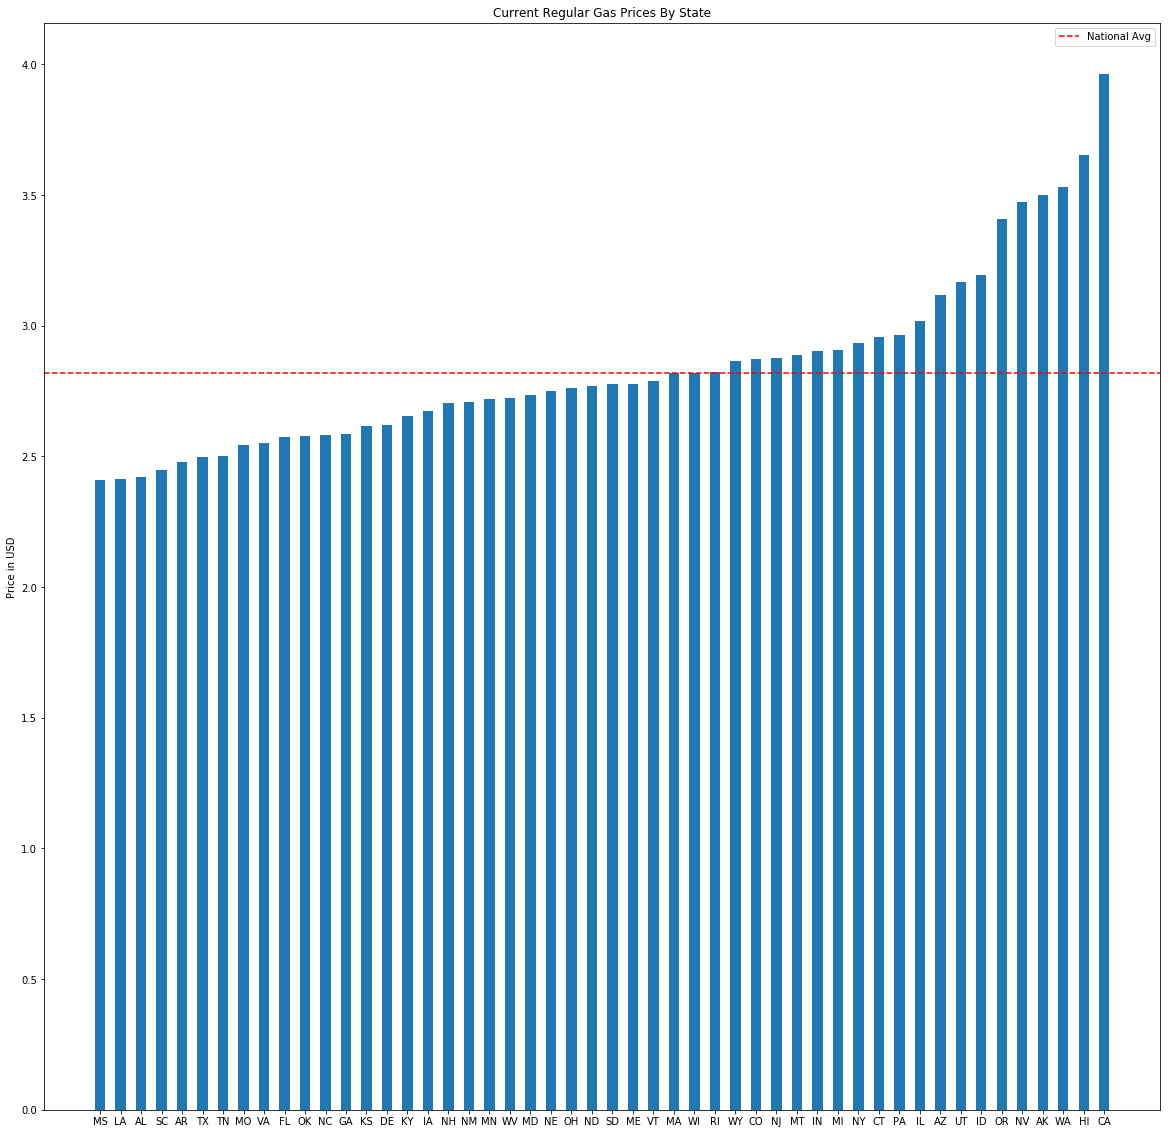

In [18]:
fig,ax = plt.subplots(figsize=(20,20))
plt.bar(state['State'],p,width=.5)
plt.axhline(y=ref,color='r',linestyle='--',label="National Avg")
labels = ["National Avg"]
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles = handles[1:], labels = labels)
plt.ylabel('Price in USD')
plt.title('Current Regular Gas Prices By State')
plt.rcParams["figure.figsize"] = [20,20]

In [19]:
#get historical data
import pyodbc
cnxn = pyodbc.connect('driver={SQL Server};server=modeling\modeling;database=Modeling;trusted_connection=true')
cursor = cnxn.cursor()

In [20]:
query = '''
SELECT Scrape_Date, Header, State, Grade, Price
  FROM (select scrape_date, header, state, regular, midgrade, premium, diesel from modeling.dbo.aaa_gas (nolock)where datepart(yy,scrape_date)=2018
  and Header = 'Current Avg.') p
  UNPIVOT
  (price for grade in (regular, midgrade, premium, diesel)
  ) as unpiv;
  
'''
##READING IN DATA   
all_data1 = pd.read_sql(query, cnxn)

In [21]:
#format price
p = [all_data1['Price'][i].replace('$','') for i in range(0,len(all_data1['Price']))]
for i in range(0,len(p)):
    p[i] = float(p[i])

In [22]:
all_data1['Price2'] = p

In [62]:
cols = ['Scrape_Date','State','Grade','Price2']
p_df = all_data1[cols]
p_df = p_df.rename(index=str,columns={"Price2":"Price"})
p_df= p_df.sort_values('Scrape_Date')

In [24]:
#Regular grade only
reg = p_df[p_df['Grade'].isin(['regular'])]

In [26]:
#format date
reg['Scrape_Date']=pd.to_datetime(reg['Scrape_Date'])

C:\Users\cherring\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


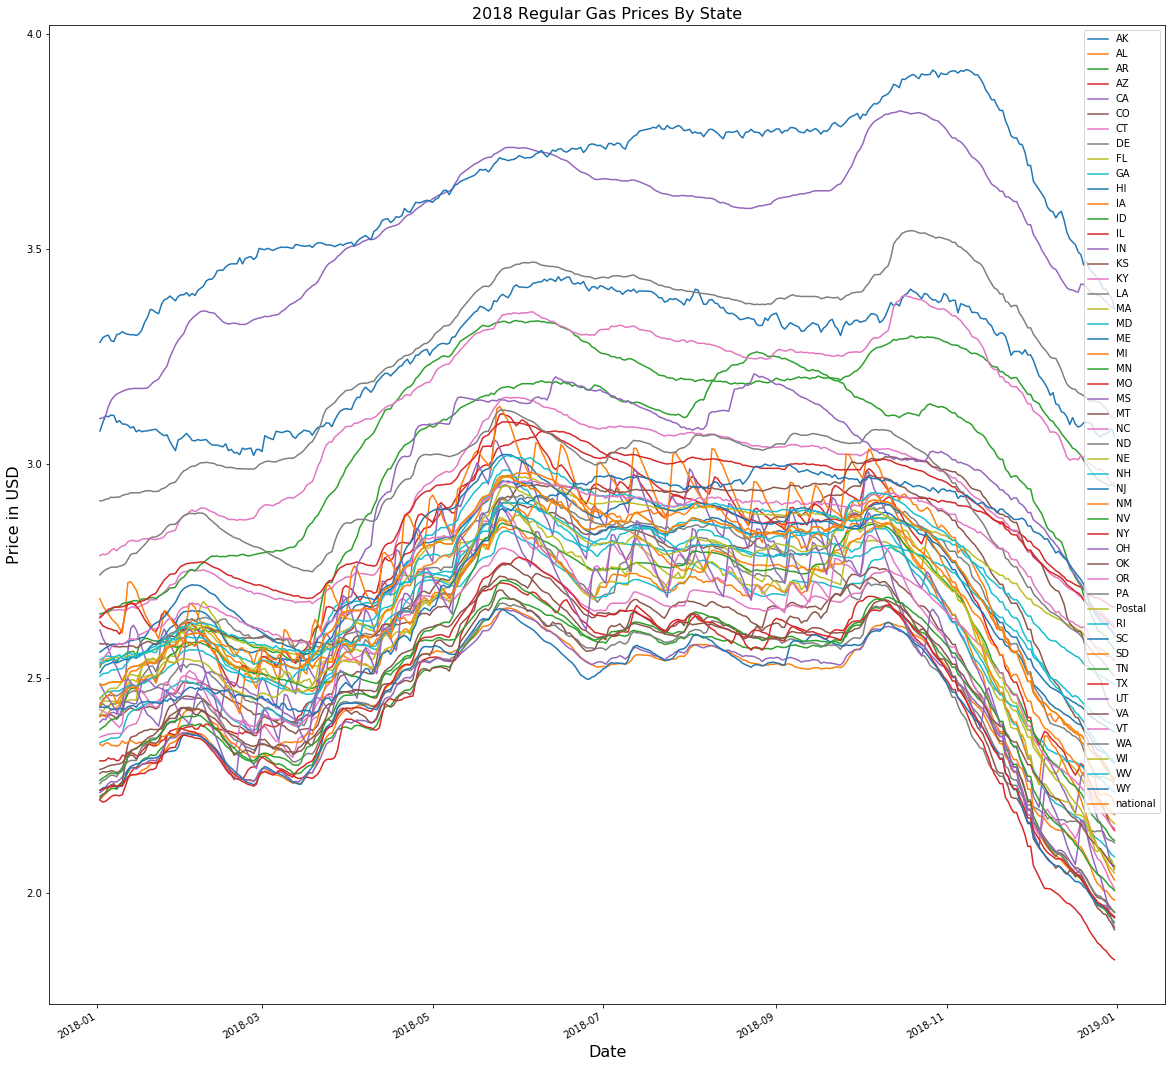

In [27]:
#regular only
fig,ax = plt.subplots(figsize=(20,20))
for label, reg in reg.groupby('State'):
    plt.plot(reg['Scrape_Date'],reg['Price'],label=label)
    plt.ylabel('Price in USD',fontsize=16)
    plt.title('2018 Regular Gas Prices By State',fontsize=16)
    plt.xlabel('Date',fontsize=16)
    plt.gcf().autofmt_xdate()
plt.legend()

In [34]:
#national prices for all grades
grade_df = p_df[p_df['State'].isin(['national'])]

In [35]:
grade_df['Scrape_Date']=pd.to_datetime(grade_df['Scrape_Date'])

C:\Users\cherring\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


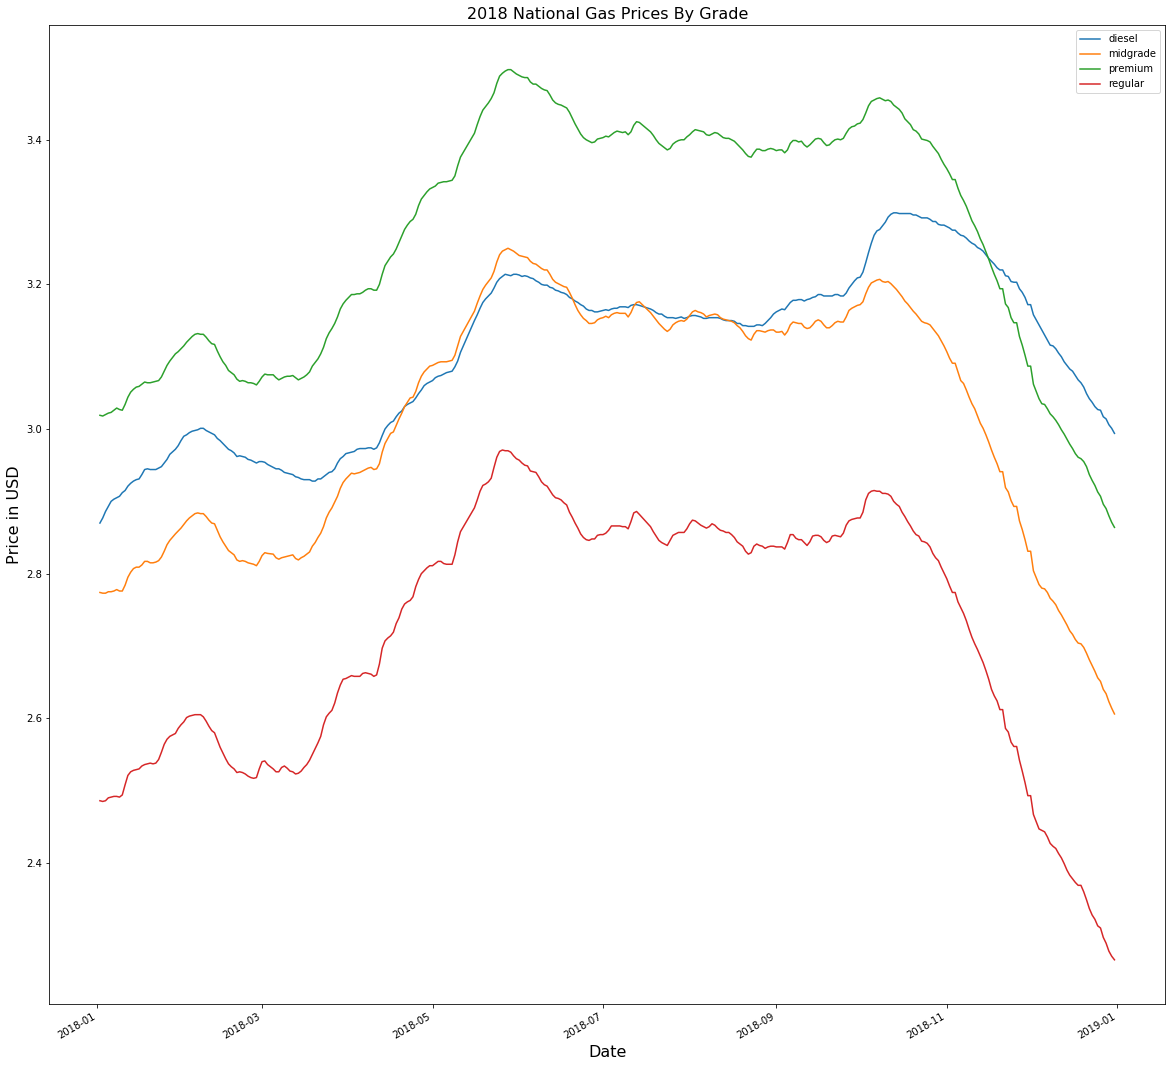

In [36]:
fig,ax = plt.subplots(figsize=(20,20))
for label, grade_df in grade_df.groupby('Grade'):
    plt.plot(grade_df['Scrape_Date'],grade_df['Price'],label=label)
    plt.ylabel('Price in USD',fontsize=16)
    plt.title('2018 National Gas Prices By Grade',fontsize=16)
    plt.xlabel('Date',fontsize=16)
    plt.gcf().autofmt_xdate()
plt.legend()

In [39]:
#dynamic plot in dash web app
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='cch1293', api_key='AHzw9C4hThWSLKMbBlTd')

In [40]:
statelist = p_df['State'].unique()
statelist = list(statelist)
gradelist = p_df['Grade'].unique()
gradelist = list(gradelist)

In [46]:
p_df['Scrape_Date']=pd.to_datetime(p_df['Scrape_Date'])

In [70]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(children=[
    html.H4(children = 'States'),
    dcc.Dropdown(
        id='dropdown',
        options=[
            {'label': i, 'value': i} for i in statelist
        ],
        multi=False, placeholder= 'Filter by state...',value='national'
    ),html.Div(id='table-container'),
    
    dcc.Graph(
        id='example-graph',
        figure={
            'data':[ 
                [{
                    'x' : p_df['Scrape_Date'].unique(),
                    'y' : list(p_df['Price'][p_df['Grade'].isin(['regular']) & p_df['State'].isin([i])]),
                    'mode': 'lines',
                    'name' : 'Regular'
                },
                {
                    'x' : p_df['Scrape_Date'].unique(),
                    'y' : list(p_df['Price'][p_df['Grade'].isin(['diesel'])& p_df['State'].isin([i])]) ,
                    'mode': 'lines',
                    'name' : 'Diesel'
                },
                {
                    'x' : p_df['Scrape_Date'].unique(),
                    'y' : list(p_df['Price'][p_df['Grade'].isin(['premium']) & p_df['State'].isin([i])]),
                    'mode': 'lines',
                    'name' : 'Premium'
                },
                {
                    'x' : p_df['Scrape_Date'].unique(),
                    'y' : list(p_df['Price'][p_df['Grade'].isin(['midgrade']) & p_df['State'].isin([i])]),
                    'mode': 'lines',
                    'name' : 'Midgrade'}] for i in statelist
                        
                
            ],
            
            'layout': {
                'title': 'Gas Prices By State and Fuel Grade'
            }
        }
    )
])

#plt.gcf().autofmt_xdate()
  
@app.callback(
    dash.dependencies.Output('example-graph','figure'),
    [dash.dependencies.Input('dropdown', 'value')]
)


def update_graph(val):
    traces = []
    df = p_df[p_df['State']==val]        
    trace0 = {
            'x' : p_df['Scrape_Date'].unique(),
            'y' : list(df['Price'][df['Grade'].isin(['regular'])]),
            'mode': 'lines',
            'name' : 'Regular'
        }
    traces.append(trace0)
    trace1 = {
                'x' : p_df['Scrape_Date'].unique(),
                'y' : list(df['Price'][df['Grade'].isin(['diesel'])]),
                'mode': 'lines',
                'name' : 'Diesel'
            }
    traces.append(trace1)
    trace2 = {
                'x' : p_df['Scrape_Date'].unique(),
                'y' : list(df['Price'][df['Grade'].isin(['premium'])]),
                'mode': 'lines',
                'name' : 'Premium'
            }
    traces.append(trace2)
    trace3 = {
                'x' : p_df['Scrape_Date'].unique(),
                'y' : list(df['Price'][df['Grade'].isin(['midgrade'])]),
                'mode': 'lines',
                'name' : 'Midgrade'}
    traces.append(trace3)
    
    layout= {
                'title': 'Gas Prices By State and Fuel Grade'
            }

        
    figure = {'data': traces,'layout':layout}
    #[{'data': traces[traces['State']==val]} for val in statelist] 
    return figure
    #return traces
   
            
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [01/Jun/2019 13:41:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2019 13:41:51] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2019 13:41:51] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2019 13:41:51] "POST /_dash-update-component HTTP/1.1" 200 -
